# Use AutoAI and multiple data to predict sale quantity with `ibm-watson-machine-learning`

This notebook contains the steps and code to demonstrate support of AutoAI experiments for multi files data sets in Watson Machine Learning service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.7.


## Learning goals

The learning goals of this notebook are:

-  Define Watson Machine Learning experiment for multiple data sets. 
-  Work with experiments to train AutoAI models.
-  Compare trained models quality and select the best one for further deployment.
-  Batch deployment and score the trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Multiple data sets](#obm)
3.	[Optimizer definition](#definition)
4.	[Experiment Run](#run)
5.	[Pipelines comparison and testing](#comparison)
6.	[Deploy and Score](#scoring)
7.  [Clean up](#cleanup)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**


### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide Cloud `API key` and `location`.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.


You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve the instance `location`.

```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```


**NOTE:** You can also get a service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, and then copy the created key and paste it in the following cell.


**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'PUT_YOUR_KEY_HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` and dependecies
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below

In [4]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [5]:
client.set.default_space(space_id)

'SUCCESS'

<a id="obm"></a>
## 2. Multiple data sets

### Connections to COS

In next cell we read the COS credentials from the space.

In [6]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']

### Training data sets

Download training data from git repository and upload it to a COS.  
This example uses the [Go sale dataset](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/dcf7b09bd340e6ff9a2d1869631f3753).

In [7]:
bucketname = cos_credentials['bucket_name']

In [8]:
import os, wget, zipfile

filenames = ['go_1k.csv', 'go_daily_sales.csv', 'go_methods.csv', 'go_products.csv', 'go_retailers.csv']
base_url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/data/go_sales/'

for filename in filenames:
    if not os.path.isfile(filename): wget.download(base_url + filename)

### Training data connection
The code in next cell defines connections to created assets.

**Note:** `data_join_node_name` (any string) will be used to define data joins in next step.

In [9]:
from ibm_watson_machine_learning.helpers import DataConnection, S3Connection, S3Location

data_connections = []
for filename in filenames:
    data_connection = DataConnection(
        data_join_node_name=filename,
        connection=S3Connection(endpoint_url=cos_credentials['endpoint_url'],
                                access_key_id=cos_credentials['credentials']['editor']['access_key_id'],
                                secret_access_key=cos_credentials['credentials']['editor']['secret_access_key']),
        location=S3Location(bucket=cos_credentials['bucket_name'],
                            path=filename)
    )
    data_connection.write(data=filename, remote_name=filename)
    data_connections.append(data_connection)

### DataJoin graph definition
The code in next cell defines the join graph. Join graph describes how data sets whould be join together.
The dot syntax is used. First, graph nodes are defined using `data_join_node_names`.
Next, edges between nodes with join columns names (`from_column`, `to_column`).


**Note:** `data_join_graph.visualize()` is used to inspect data join graph definition and correct if needed.

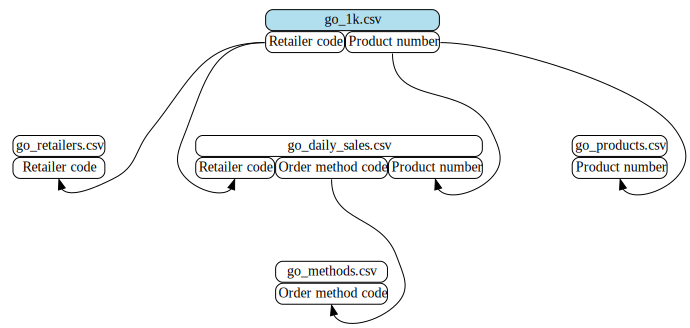

In [10]:
from ibm_watson_machine_learning.preprocessing import DataJoinGraph

data_join_graph = DataJoinGraph()

for filename in filenames: 
    data_join_graph.node(name=filename)

data_join_graph.edge(from_node="go_1k.csv", to_node="go_daily_sales.csv", 
                     from_column=["Retailer code", "Product number"], to_column=["Retailer code", "Product number"])
data_join_graph.edge(from_node="go_daily_sales.csv", to_node="go_methods.csv",
                     from_column=["Order method code"], to_column=["Order method code"])
data_join_graph.edge(from_node="go_1k.csv", to_node="go_products.csv",
                     from_column=["Product number"], to_column=["Product number"])
data_join_graph.edge(from_node="go_1k.csv", to_node="go_retailers.csv",
                     from_column=["Retailer code"], to_column=["Retailer code"])

data_join_graph.visualize()

Data join graph contains the information how multi source data should be joined as part of preprocessing step in AutoAI experiment.

<a id="definition"></a>
## 3. Optimizer definition

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [11]:
from ibm_watson_machine_learning.experiment import AutoAI

experiment = AutoAI(wml_credentials, space_id=space_id)


pipeline_optimizer = experiment.optimizer(
            name="Go sales quantity",
            prediction_type=AutoAI.PredictionType.REGRESSION,
            prediction_column='Quantity',
            scoring=AutoAI.Metrics.R2_SCORE,
            max_number_of_estimators=1,
            data_join_graph=data_join_graph,
            test_size=0.5
        )

Configuration parameters can be retrieved via `pipeline_optimizer.get_params()`.

<a id="run"></a>
## 4. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [12]:
fit_details = pipeline_optimizer.fit(training_data_reference=data_connections, background_mode=False)

Training job cbdc5d77-f9b6-4a70-8b83-f31744cd23d7 completed: 100%|████████| [06:33<00:00,  3.94s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [13]:
pipeline_optimizer.get_run_status()

'completed'

<a id="comparison"></a>
## 5. Pipelines comparison and inspection

You can list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame by calling the `summary()` method. You can
use the DataFrame to compare all discovered pipelines and select the one
you like for further testing.

In [16]:
summary = pipeline_optimizer.summary()
summary

,Number of enhancements,Estimator,holdout_explained_variance,training_mean_squared_log_error,holdout_median_absolute_error,holdout_root_mean_squared_log_error,holdout_mean_squared_error,training_explained_variance,training_r2_(optimized),training_median_absolute_error,training_mean_squared_error,training_root_mean_squared_error,holdout_r2,training_mean_absolute_error,holdout_root_mean_squared_error,holdout_mean_absolute_error,holdout_mean_squared_log_error,training_root_mean_squared_log_error
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_4,3,RandomForestRegressorEstimator,0.728364,0.611755,21.028166,0.826455,37997.260891,0.711985,0.707171,20.123847,23894.207999,147.753812,0.726338,57.031080,194.928861,59.842727,0.683028,0.781476
Pipeline_3,2,RandomForestRegressorEstimator,0.743080,0.482505,16.200000,0.678356,35969.225305,0.701753,0.696659,16.941667,21626.644124,144.832989,0.740945,56.441796,189.655544,55.352153,0.460167,0.693397
Pipeline_1,0,RandomForestRegressorEstimator,0.724345,0.492747,15.500000,0.686044,38649.080224,0.692297,0.687544,17.516667,23193.601741,148.720343,0.721644,57.842595,196.593693,58.393610,0.470656,0.699900
Pipeline_2,1,RandomForestRegressorEstimator,0.724345,0.492747,15.500000,0.686044,38649.080224,0.692297,0.687544,17.516667,23193.601741,148.720343,0.721644,57.842595,196.593693,58.393610,0.470656,0.699900


You can visualize the scoring metric calculated on a holdout data set.

<AxesSubplot:xlabel='Pipeline Name'>

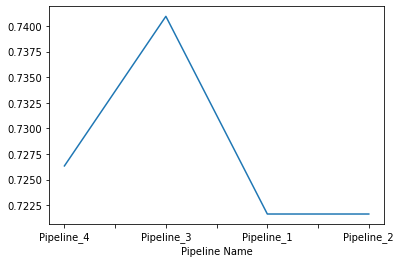

In [17]:
%matplotlib inline

summary.holdout_r2.plot()

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [18]:
best_pipeline = pipeline_optimizer.get_pipeline()

Check features importance for selected pipeline. You can see new features created during data joining and feature engineering phases.

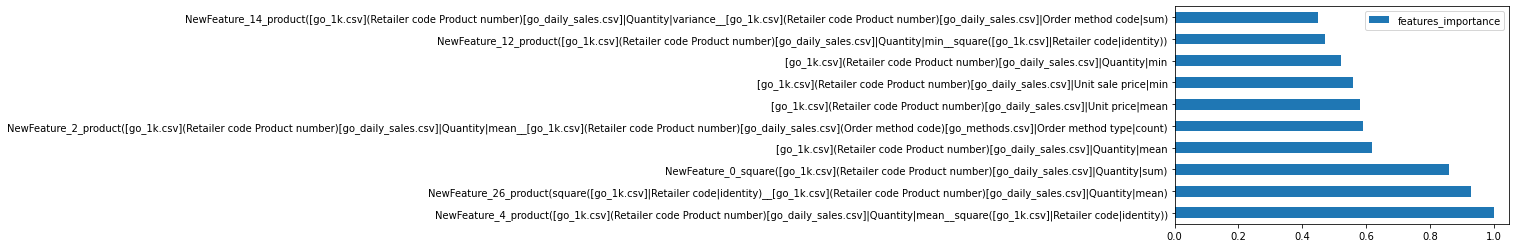

In [19]:
pipeline_optimizer.get_pipeline_details()['features_importance'].head(10).plot.barh();

### Visualize pipeline

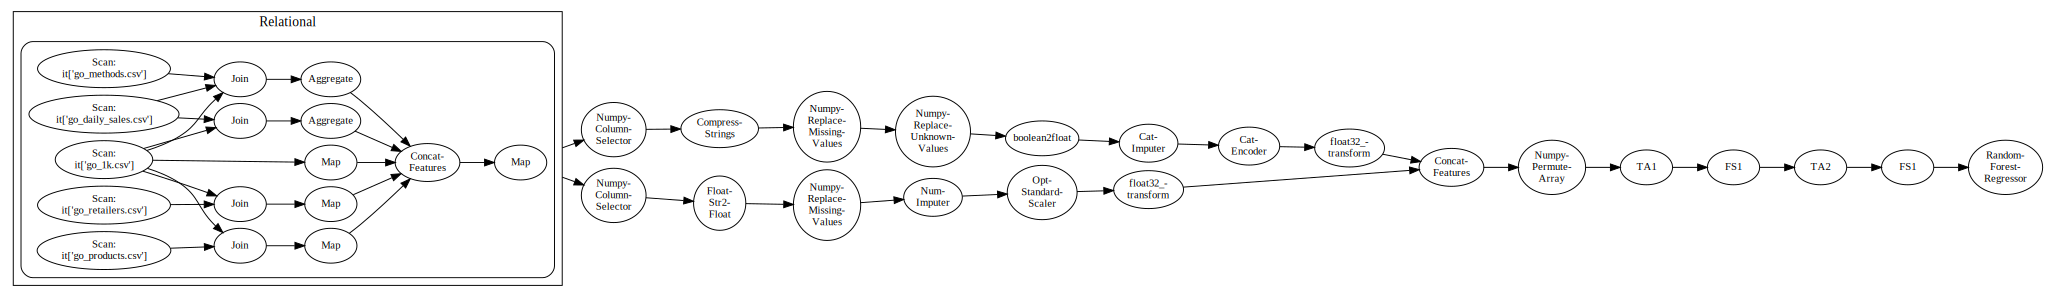

In [20]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Pipeline source code

In [ ]:
best_pipeline.pretty_print(ipython_display=True, astype='sklearn')

### Reading joined training data
You can read joined data using code in below cell.

In [22]:
train_df = pipeline_optimizer.get_preprocessed_data_connection().read()

train_X = train_df.drop(['Quantity'], axis=1).values
train_y = train_df.Quantity.values

### Test pipeline model locally

In [23]:
predicted_y = best_pipeline.predict(train_X)
predicted_y[:5]

array([32.77960855, 75.10181596, 37.1607219 , 38.75308083, 26.78486724])

<a id="scoring"></a>
## 6. Deploy and Score

In this section you will learn how to deploy and score pipeline model as batch deployment using WML instance.

In [24]:
pipeline_name = "Pipeline_1"

### Batch deployment creation

In [25]:
from ibm_watson_machine_learning.deployment import Batch

service = Batch(wml_credentials, source_space_id=space_id)

service.create(
    experiment_run_id=pipeline_optimizer.get_run_details()['metadata']['guid'],
    model=pipeline_name, 
    deployment_name="Product Quantity with OBM and KB AutoAI"
    )

Preparing an AutoAI Deployment...
Published model uid: f736c73f-b005-48ba-b422-1c0d6db8103a
Deploying model f736c73f-b005-48ba-b422-1c0d6db8103a using V4 client.


#######################################################################################

Synchronous deployment creation for uid: 'f736c73f-b005-48ba-b422-1c0d6db8103a' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a2d7b872-2240-4dad-9c71-8b4a0d3d4081'
------------------------------------------------------------------------------------------------




To show all available information about the deployment use the `.get_params()` method:

In [26]:
service.get_params()

{'entity': {'asset': {'id': 'f736c73f-b005-48ba-b422-1c0d6db8103a'},
  'batch': {},
  'custom': {},
  'deployed_asset_type': 'model',
  'hybrid_pipeline_hardware_specs': [{'hardware_spec': {'name': 'M-Spark',
     'num_nodes': 2},
    'node_runtime_id': 'auto_ai.obm'},
   {'hardware_spec': {'name': 'M'}, 'node_runtime_id': 'autoai.kb'}],
  'name': 'Product Quantity with OBM and KB AutoAI',
  'space_id': 'd70a423e-bab5-4b24-943a-3b0b29ad7527',
  'status': {'state': 'ready'}},
 'metadata': {'created_at': '2021-02-15T13:37:34.583Z',
  'id': 'a2d7b872-2240-4dad-9c71-8b4a0d3d4081',
  'modified_at': '2021-02-15T13:37:34.583Z',
  'name': 'Product Quantity with OBM and KB AutoAI',
  'owner': 'IBMid-55000091VC',
  'space_id': 'd70a423e-bab5-4b24-943a-3b0b29ad7527'}}

### Running batch job
You can make scoring request by calling `run_job()` on deployed pipeline. The job will do data join and next call the machine learning pipeline.

**Action**: Define: `scoring_data_reference` that contains connection to data sets (multiple files). In the below example training data is used for simplicity.

In [27]:
scoring_data_reference = data_connections

**Action:** Define `output_data_reference` that will contain predictions calculated for `scoring_data_reference`.

In [32]:
output_filename = "quantity_product_batch_output.csv"

output_data_reference = DataConnection(
        connection=S3Connection(endpoint_url=cos_credentials['endpoint_url'],
                                access_key_id=cos_credentials['credentials']['editor']['access_key_id'],
                                secret_access_key=cos_credentials['credentials']['editor']['secret_access_key']),
        location=S3Location(bucket=cos_credentials['bucket_name'],
                            path=output_filename)
)

Run the batch job.

In [33]:
job_details = service.run_job(
    payload=scoring_data_reference,
    output_data_reference=output_data_reference,
    background_mode=False)



##########################################################################

Synchronous scoring for id: '0ef3463b-1818-439a-8d54-d9d4ecb35bad' started

##########################################################################


queued.........................
running................
completed
Scoring job  '0ef3463b-1818-439a-8d54-d9d4ecb35bad' finished successfully.


### Getting predictions

The code in cell below downloads output csv file and reads it as pandas dataframe.

In [37]:
predictions = service.get_job_result(service.get_job_id(job_details))
predictions.head()

,prediction
0,39.20
1,93.55
2,57.10
3,31.20
4,29.30


<a id="cleanup"></a>
## 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 9. Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `ibm-watson-machine-learning` to run AutoAI experiments. 
 
 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.


Copyright © 2020, 2021 IBM. This notebook and its source code are released under the terms of the MIT License.